# The Havoc Paradox: Notebook for Generating All Tables and Figures

## Imports and Data Loading

First, we'll need to import the proper libraries and load the aggregated data to generate the tables/figures. This will load all mutation distance data and filter the inputs to those with nonzero length. We will also load the coverage and execution speed data for the longer 24 hour experiments. 

In [1]:
## CHANGE IF YOU WANT TO USE FRESH-BAKED DATA ##
DATA_DIR = "../data/aggregated/fresh-baked"

import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import warnings

warnings.filterwarnings('ignore')

from mutation_distance_plots import *
from coverage_util import *
from exec_util import *

# Define a color palette
palette = sns.color_palette("husl", 6)  # "husl" generates distinct colors

colors = {"Zest": palette[0], "BeDivFuzz": palette[1], "EI": palette[2], "Zeugma": palette[3], "Random": palette[4], "Zest-Mini": palette[5]}

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Mutation Distance aggregated data #
mutation_df = pd.read_csv(os.path.join(DATA_DIR, "mutation_distances.csv"))
mutation_df = mutation_df.dropna()
all_input_df = mutation_df[~mutation_df['algorithm'].str.contains('saved')]
all_input_df_nonzero_len = all_input_df[(all_input_df['parent_len'] != 0) & (all_input_df['current_len'] != 0)]

# Coverage aggregated data
cov_df = pd.read_csv(os.path.join(DATA_DIR, "coverage.csv"))
corpus_size_df = pd.read_csv(os.path.join(DATA_DIR, "corpus_sizes.csv"))

# Execution speed aggregated data
exec_df = pd.read_csv(os.path.join(DATA_DIR, "campaign_trials_detail.csv"))

## RQ1: Mutation Distances

### Figure 8: Mutation Distances for Google Closure

Our first main evaluation figure shows the mutation distances (byte-level vs string) for the Google Closure benchmark in a scatter plot. Run the following to generate the plot from our mutation distance data.

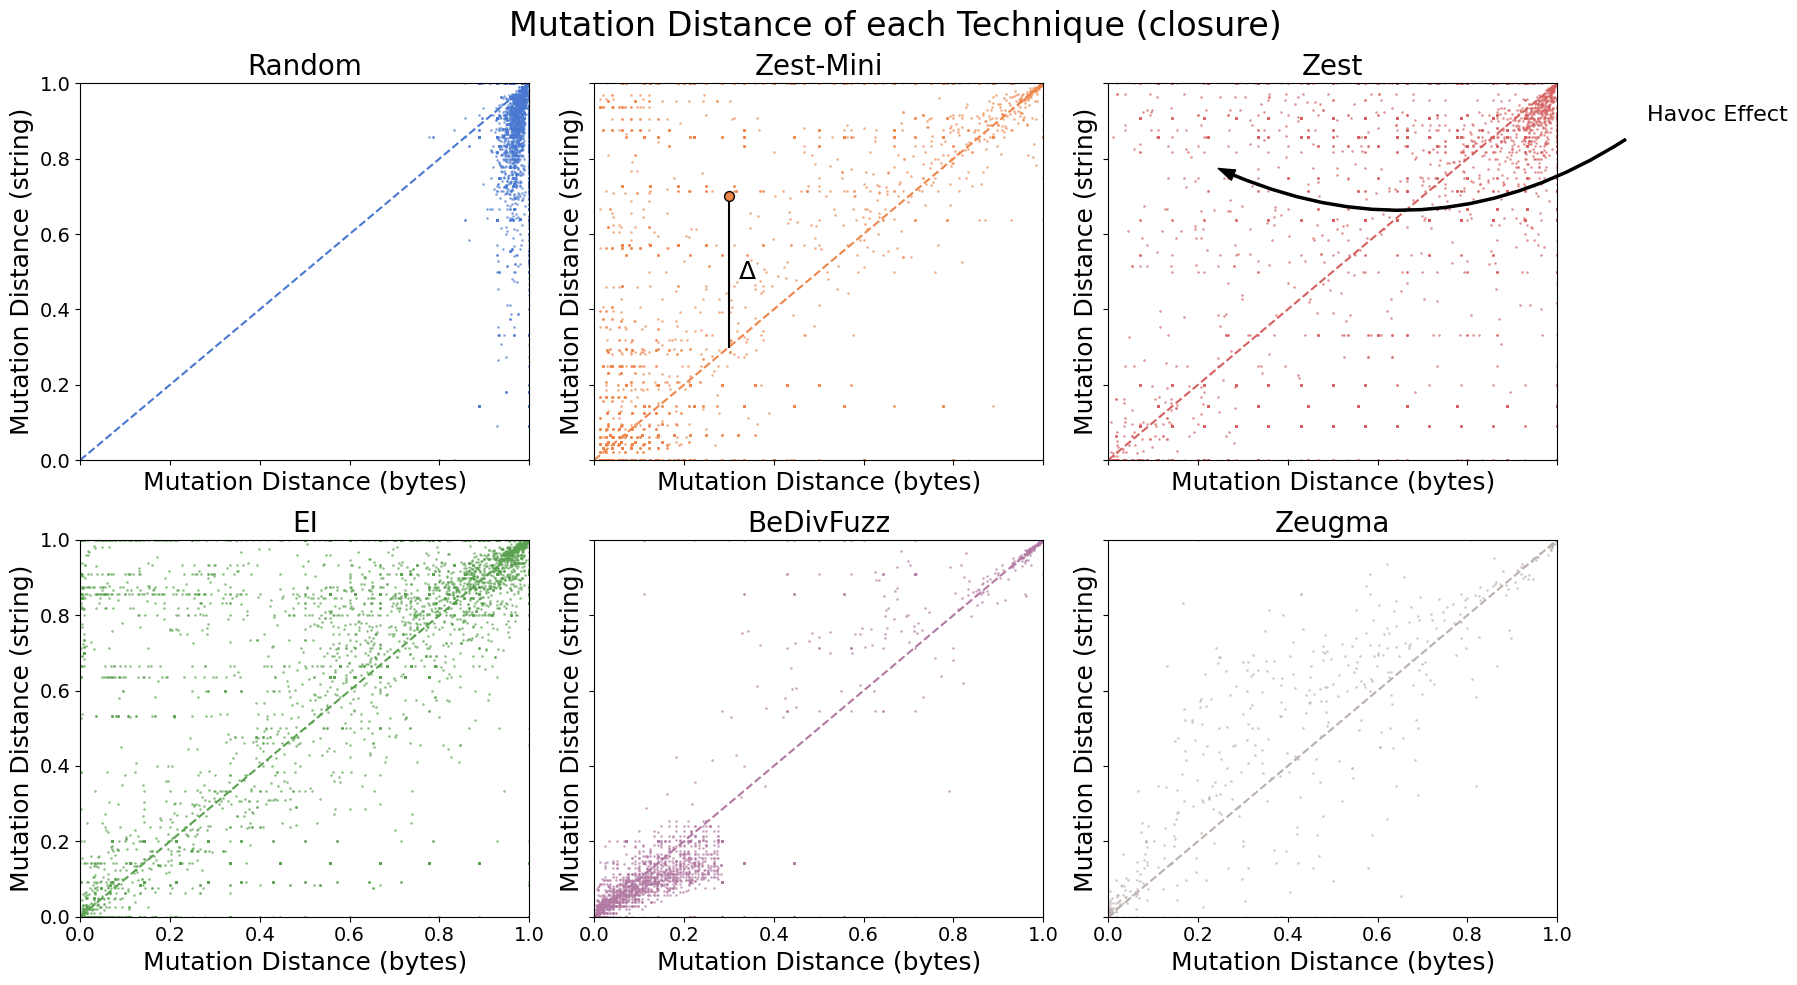

In [2]:
# Generate the plot
fig = plot_mut_distance_scatter(all_input_df_nonzero_len, "closure", True)
plt.savefig("figs/scatter/mutation_distance_scatter_closure.png", dpi=300, bbox_inches='tight')

### Figure 9: Heatmap of Normalized Mutation Distance Difference for all Techniques/Benchmarks

We also include normalized mutation distance differences for all of the techniques and benchmarks. Run the following to generate this from the mutation distance data.

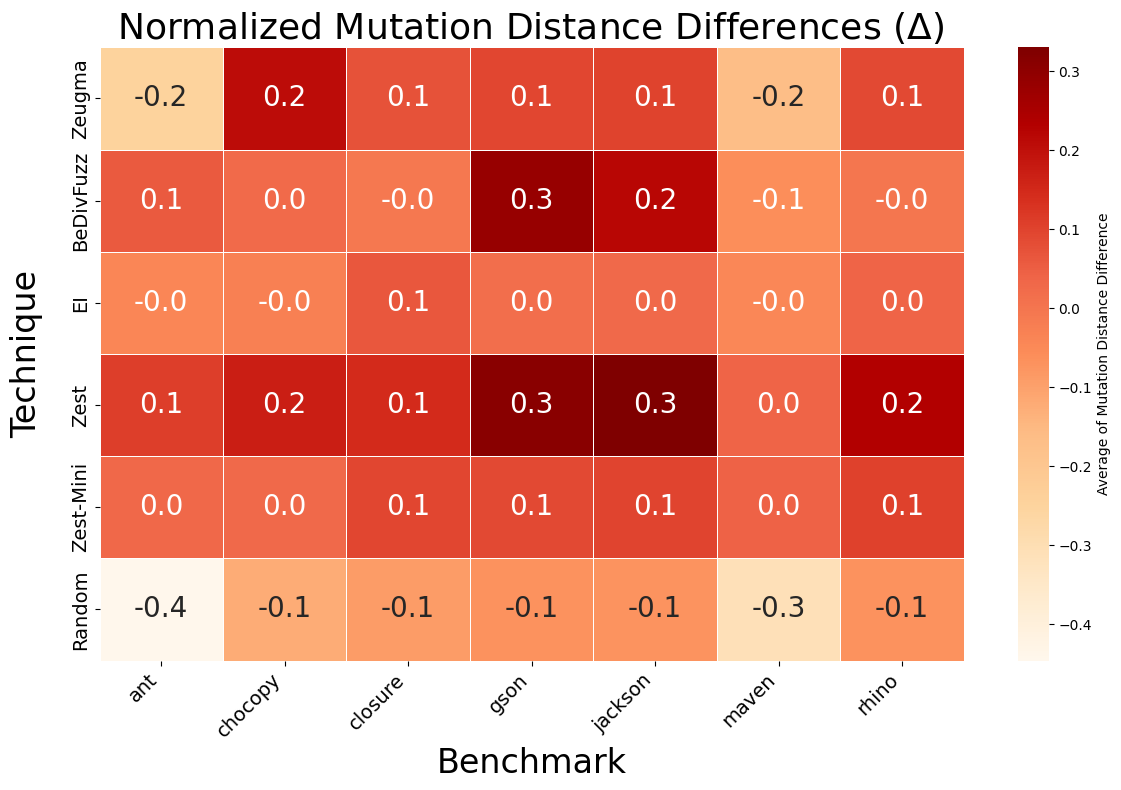

In [ ]:
fig = plot_mutation_dist_heatmap(all_input_df_nonzero_len)
plt.savefig("figs/havoc_mutation_distance_heatmap.pdf", bbox_inches='tight')

### Figure 10: Zero Mutation Rate

Each mutation technique has a chance of producing a "zero mutation", meaning the child and parent inputs are identical. Run the following to plot the zero-mutation rate for each of the techniques on all benchmarks.

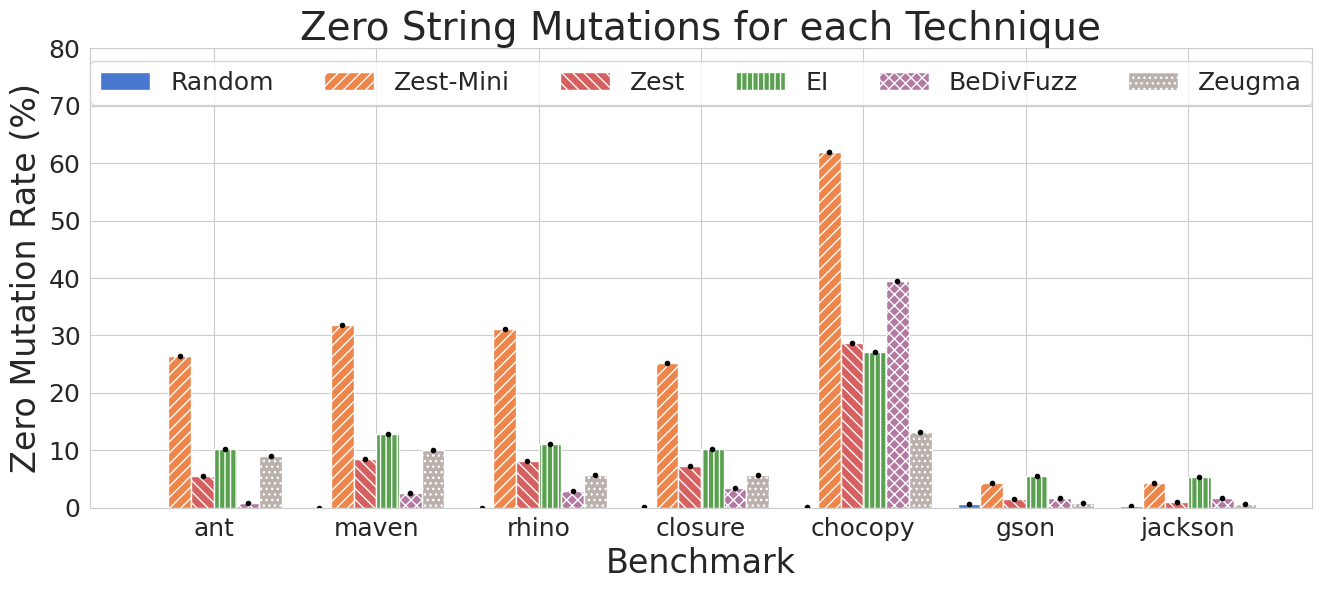

In [4]:
plt, zero_mutation_data = create_zero_mutation_plot(all_input_df_nonzero_len)
plt.savefig("figs/zero_mutations.pdf", bbox_inches='tight')

## RQ2: Validity-Preserving Mutations

### Figure 11: Validity-Preserving Mutation Rate across all Techniques/Benchmarks

In RQ2, we look at how often mutations preserve input validity. We can generate this plot from our mutation distance data by running the following code.

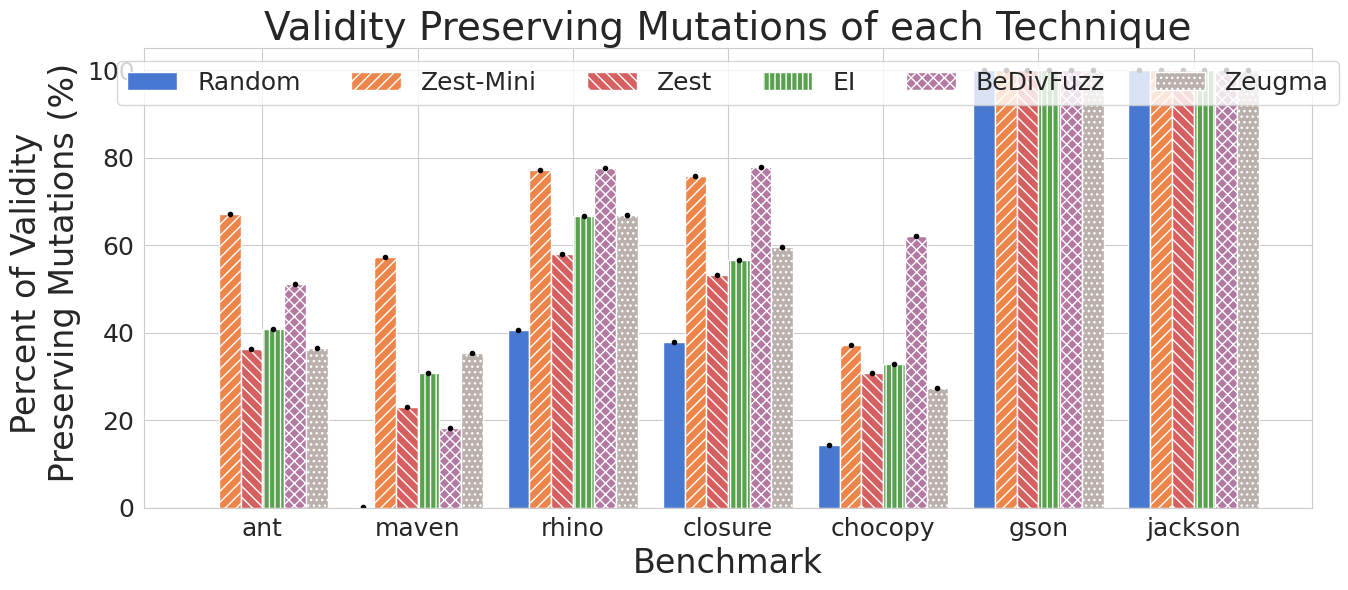

In [5]:
plt, success_data = create_success_rate_chart(all_input_df_nonzero_len)
plt.savefig("figs/mutation_validity.pdf", bbox_inches='tight')

## RQ3: Code Coverage

### Figure 12: Coverage over Time Plots

Our coverage data is generated across longer, 24 hour experiments. We can first generate the coverage-over-time plots for each of the techniques.

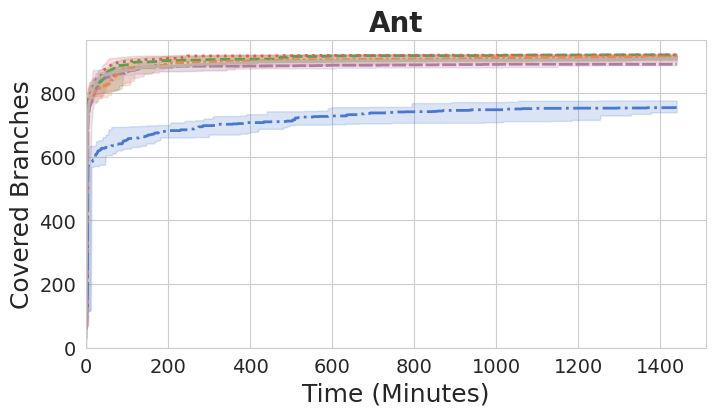

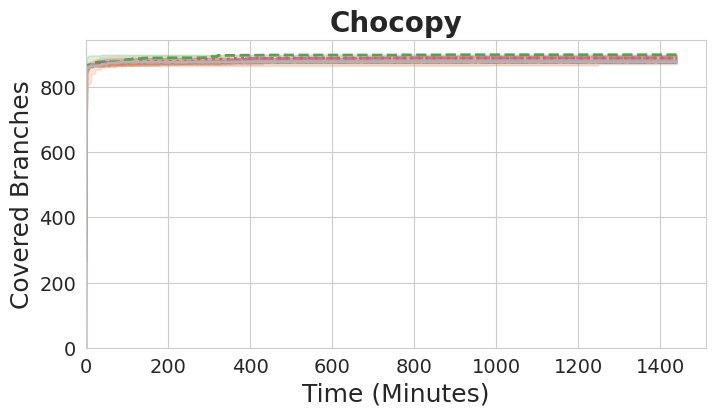

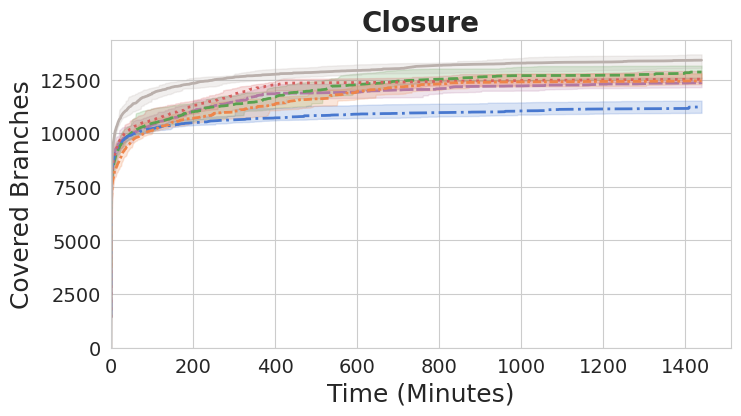

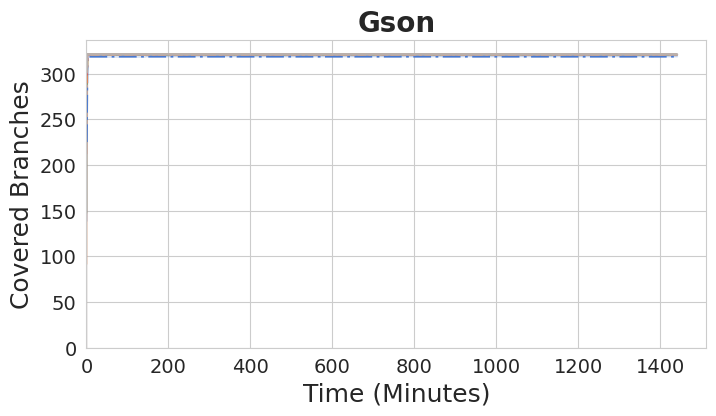

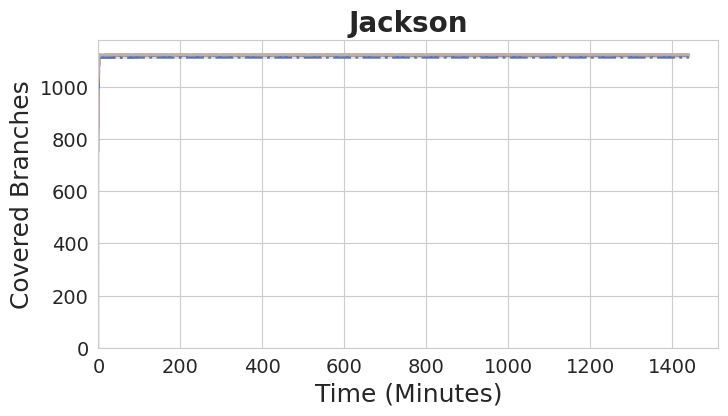

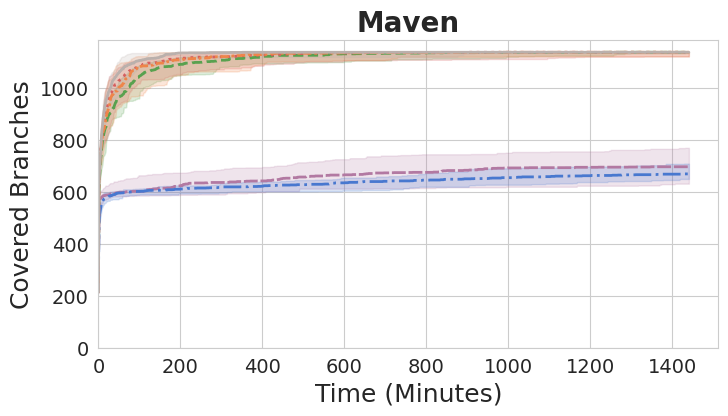

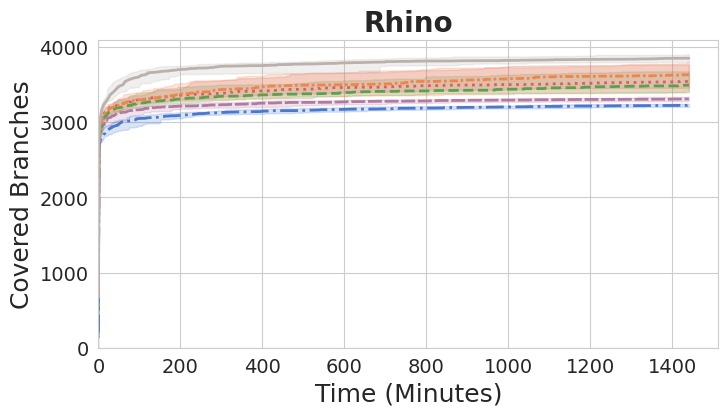

In [6]:
create_coverage_over_time_plots(cov_df, "figs")

### Table 2: Full Coverage Results

Next, we can generate the full coverage table results. This includes the raw branch coverage numbers of all baselines/techniques and whether the data shows a statistically significant difference from our coverage-guided baseline Zest.

First, we'll need to process the data to generate trial-bounded and time-bounded results.

In [7]:
# Construct time-bounded and trial-bounded coverage data
cov_data = process_cov_data(corpus_size_df, cov_df)
cov_data = cov_data[(cov_data['fuzzer'] != 'BeDivFuzz-Simple') & (cov_data['fuzzer'] != 'Zeugma-None')]
cov_data = get_aggregated_coverage(cov_data)

Processing coverage data...
Aggregating time/trial-bounded coverage data...


100%|██████████████████████████████| 7/7 [00:00<00:00, 261.36it/s]

100%|██████████████████████████████| 7/7 [00:00<00:00, 248.07it/s]

100%|██████████████████████████████| 7/7 [00:00<00:00, 251.07it/s]

100%|██████████████████████████████| 7/7 [00:00<00:00, 252.95it/s]

100%|███████████████████████████████| 6/6 [00:00<00:00, 34.34it/s]


Next, we can generate the latex table from the paper. We'll print a CSV of the results and populate the table to `tables/table_2.tex`

In [8]:
# Print summary of the aggregated trial-bounded and time-bounded data
print(tabulate(cov_data, headers='keys', tablefmt='csv', showindex=False))

# Generate the LaTeX table
latex_table = generate_cov_latex_table(cov_data)

# Write the table to the output file
with open("tables/table_2.tex", 'w') as f:
    f.write(latex_table)

print(f"LaTeX table written to tables/table_2.tex")

fuzzer     subject      trial_bound_coverage    time_bound_coverage    normalized_coverage  trial_bound_coverage_sig    time_bound_coverage_sig    normalized_coverage_sig
---------  ---------  ----------------------  ---------------------  ---------------------  --------------------------  -------------------------  -------------------------
Zest-Mini  rhino                      3514.5                 3631.5                  753    nan                         nan                        nan
Zest-Mini  ant                         911.5                  914                     59    nan                         nan                        nan
Zest-Mini  gson                        321                    321                    289    nan                         nan                        nan
Zest-Mini  maven                      1085.5                 1138                    250    nan                         nan                        nan
Zest-Mini  jackson                    1121          

NameError: name 'args' is not defined

### Figure 13: Saved Input Mutation Distance Ratio

Finally, we include a plot showing the mutation distance ratio of saved inputs to all inputs. Run the following to generate this barplot.

In [ ]:
create_saved_all_ratio_plot(all_input_df_nonzero_len, "figs/mutation_distance_ratio.pdf")

## RQ4: Runtime Overhead

### Table 3: Runtime Slowdown

Our final RQ looks at runtime overhead. Run the following to generate the Latex table showing runtime slowdowns of each of the context-aware mutation techniques.

In [ ]:
# Process exec speed data
trial_df = analyze_fuzzer_slowdown(exec_df)

# Print summary of results
print("\nSummary of Results (Geometric Mean Slowdowns):")
for benchmark, group in trial_df.groupby('benchmark'):
    print(f"\nBenchmark: {benchmark}")
    for _, row in group.iterrows():
        print(f"  {row['technique']}: {row['geo_mean']:.2f} */ {row['std_dev']:.2f} (from {row['count']} repetitions)")

# Generate Latex table
latex_table = generate_exec_latex_table(trial_df)
with open("tables/table_3.tex", "w") as f:
    f.write(latex_table)